In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors

In [23]:
#Set random seed for reproducibility
np.random.seed(42)

# Simulate user features
n_users = 50000
data = {
    "user_id": np.arange(1, n_users + 1),
    "annual_purchase_value": np.random.uniform(10, 10000, size=n_users),
    "session_activity": np.random.uniform(1, 10, size=n_users),
    "membership_plan": np.random.choice(["monthly", "annual"], size=n_users, p=[0.8, 0.2]),
}

df = pd.DataFrame(data)

# Stronger treatment assignment: logistic based on features
logit = -1 + 0.00005 * df['annual_purchase_value'] + 0.05 * (df['session_activity'] / 10) + np.where(df['membership_plan'] == "annual", 0.2, -0.1)
prob = 1 / (1 + np.exp(-logit))  # Sigmoid
df['avail_free_shipping'] = np.random.binomial(1, p=np.clip(prob, 0, 1))

# Simulate baseline conversion probability
baseline_prob = 0.1 + 0.00002 * df['annual_purchase_value'] + 0.02 * (df['session_activity'] / 10)

# Boost conversion for treated (free shipping) users
df['membership_conversion_prob'] = np.where(
    df['avail_free_shipping'] == 1,
    baseline_prob + 0.05,  # 5% uplift
    baseline_prob
)

# Simulate membership conversion
df['membership_conversion'] = np.random.binomial(1, p=np.clip(df['membership_conversion_prob'], 0, 1))

# Drop temp columns
df.drop(columns=['membership_conversion_prob'], inplace=True)

# Create a DataFrame and transform the attributes for score generation

df['user_id'] = df['user_id'].astype(int)
df['annual_purchase_value'] = df['annual_purchase_value'].astype(int)
df['session_activity'] = df['session_activity'].astype(int)
#drop_first=True removes one category to avoid multicollinearity (e.g., only Plan_Type_annual is added).
df_encoded = pd.get_dummies(df, columns=['membership_plan'], drop_first=True)
df_encoded['membership_plan_monthly'] = df_encoded['membership_plan_monthly'].astype(int)

In [24]:
df.groupby(["membership_conversion","avail_free_shipping"])["avail_free_shipping"].count()
df.groupby(["membership_conversion","membership_plan"])["user_id"].nunique()

membership_conversion  membership_plan
0                      annual              7809
                       monthly            30880
1                      annual              2350
                       monthly             8961
Name: user_id, dtype: int64

In [25]:
# Covariates for propensity score model
X = df_encoded[['annual_purchase_value', 'session_activity', 'membership_plan_monthly']]
y = df_encoded['avail_free_shipping']  # treatment variable

# Fit logistic regression for propensity score estimation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

logreg = LogisticRegression()
logreg.fit(X_scaled, y)

LogisticRegression()

In [26]:
# Predict propensity scores
df_encoded['propensity_score'] = logreg.predict_proba(X_scaled)[:,1]
df_encoded.head(10)

,user_id,annual_purchase_value,session_activity,avail_free_shipping,membership_conversion,membership_plan_monthly,propensity_score
0,1,3751,8,0,0,1,0.292656
1,2,9507,5,0,0,1,0.360070
2,3,7322,2,1,0,1,0.336096
3,4,5990,7,1,0,1,0.317916
4,5,1568,4,1,0,1,0.271816
5,6,1568,6,1,0,1,0.270762
6,7,590,1,1,0,0,0.322109
7,8,8663,6,0,1,1,0.349410
8,9,6015,4,0,0,1,0.319935
9,10,7083,4,0,0,1,0.332144


In [27]:
# Compute inverse probability weights
treated = df_encoded['avail_free_shipping'] == 1
control = df_encoded['avail_free_shipping'] == 0

df_encoded['ipw'] = 0
df_encoded.loc[treated, 'ipw'] = 1 / df_encoded.loc[treated, 'propensity_score']
df_encoded.loc[control, 'ipw'] = 1 / (1 - df_encoded.loc[control, 'propensity_score'])
df_encoded.head(10)

/var/folders/rp/ytph6r4j1l1_gx1mb7khmgj00000gp/T/ipykernel_66665/4110040221.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[2.97533603 3.14548738 3.67895811 ... 2.48349828 3.22578506 3.34813387]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_encoded.loc[treated, 'ipw'] = 1 / df_encoded.loc[treated, 'propensity_score']


,user_id,annual_purchase_value,session_activity,avail_free_shipping,membership_conversion,membership_plan_monthly,propensity_score,ipw
0,1,3751,8,0,0,1,0.292656,1.413739
1,2,9507,5,0,0,1,0.360070,1.562671
2,3,7322,2,1,0,1,0.336096,2.975336
3,4,5990,7,1,0,1,0.317916,3.145487
4,5,1568,4,1,0,1,0.271816,3.678958
5,6,1568,6,1,0,1,0.270762,3.693280
6,7,590,1,1,0,0,0.322109,3.104539
7,8,8663,6,0,1,1,0.349410,1.537065
8,9,6015,4,0,0,1,0.319935,1.470449
9,10,7083,4,0,0,1,0.332144,1.497328


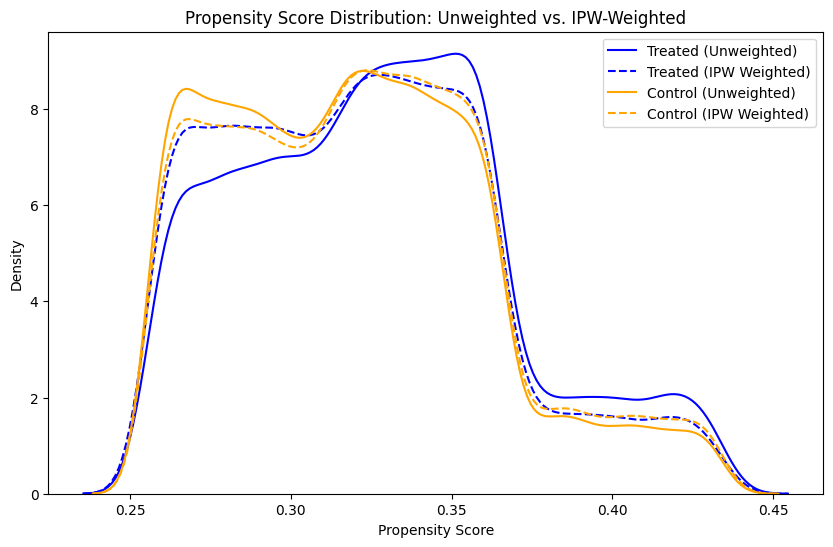

In [29]:
plt.figure(figsize=(10, 6))

# Treated group
sns.kdeplot(x=df_encoded.loc[treated, 'propensity_score'], label='Treated (Unweighted)', color='blue')
sns.kdeplot(x=df_encoded.loc[treated, 'propensity_score'], 
            weights=df_encoded.loc[treated, 'ipw'], 
            label='Treated (IPW Weighted)', linestyle='--', color='blue')

# Control group
sns.kdeplot(x=df_encoded.loc[control, 'propensity_score'], label='Control (Unweighted)', color='orange')
sns.kdeplot(x=df_encoded.loc[control, 'propensity_score'], 
            weights=df_encoded.loc[control, 'ipw'], 
            label='Control (IPW Weighted)', linestyle='--', color='orange')

plt.xlabel('Propensity Score')
plt.ylabel('Density')
plt.title('Propensity Score Distribution: Unweighted vs. IPW-Weighted')
plt.legend()
plt.show()

                 covariate  SMD_unweighted  SMD_weighted
0    annual_purchase_value          0.1494        0.0003
1         session_activity         -0.0077       -0.0001
2  membership_plan_monthly         -0.1151        0.0000


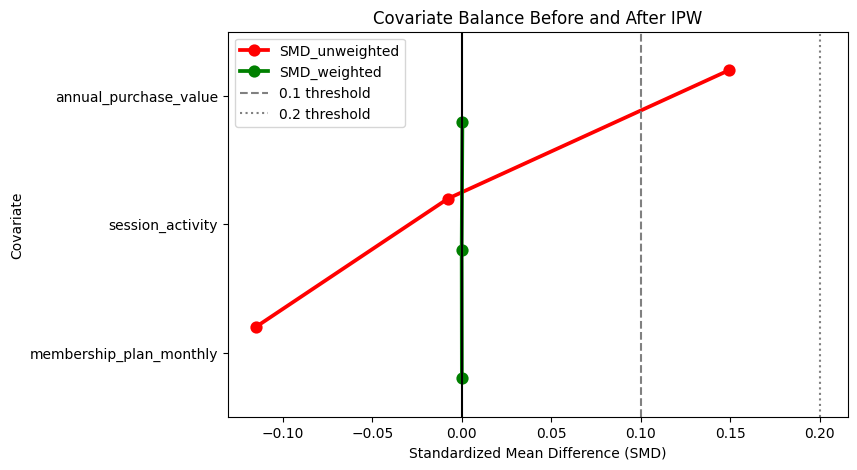

In [34]:
def smd(mean_treated, mean_control, sd_pooled):
    return (mean_treated - mean_control) / sd_pooled

def weighted_var(values, weights):
    avg = np.average(values, weights=weights)
    return np.average((values - avg)**2, weights=weights)

# List of covariates
covariates = ['annual_purchase_value', 'session_activity', 'membership_plan_monthly']

# Create masks
treated = df_encoded['avail_free_shipping'] == 1
control = df_encoded['avail_free_shipping'] == 0

# Store results
smd_results = []

for cov in covariates:
    # Unweighted means
    mean_t = df_encoded.loc[treated, cov].mean()
    mean_c = df_encoded.loc[control, cov].mean()

    # Unweighted pooled SD
    sd_t = df_encoded.loc[treated, cov].std()
    sd_c = df_encoded.loc[control, cov].std()
    sd_pooled = np.sqrt((sd_t**2 + sd_c**2)/2)

    smd_unweighted = smd(mean_t, mean_c, sd_pooled)

    # Weighted means
    wt_mean_t = np.average(df_encoded.loc[treated, cov], weights=df_encoded.loc[treated, 'ipw'])
    wt_mean_c = np.average(df_encoded.loc[control, cov], weights=df_encoded.loc[control, 'ipw'])

    # Weighted pooled SD
    wt_var_t = weighted_var(df_encoded.loc[treated, cov], df_encoded.loc[treated, 'ipw'])
    wt_var_c = weighted_var(df_encoded.loc[control, cov], df_encoded.loc[control, 'ipw'])
    wt_sd_pooled = np.sqrt((wt_var_t + wt_var_c)/2)

    smd_weighted = smd(wt_mean_t, wt_mean_c, wt_sd_pooled)

    smd_results.append({
        'covariate': cov,
        'SMD_unweighted': smd_unweighted,
        'SMD_weighted': smd_weighted
    })

# Convert results to DataFrame
smd_df = pd.DataFrame(smd_results)

print(smd_df.round(4))

# Visualize as love plot
smd_long = pd.melt(smd_df, id_vars='covariate', 
                   value_vars=['SMD_unweighted', 'SMD_weighted'],
                   var_name='type', value_name='SMD')

plt.figure(figsize=(8, 5))
sns.pointplot(data=smd_long, x='SMD', y='covariate', hue='type', 
              palette={'SMD_unweighted':'red', 'SMD_weighted':'green'}, dodge=0.4)

plt.axvline(0, color='black', linestyle='-')
plt.axvline(0.1, color='gray', linestyle='--', label='0.1 threshold')
plt.axvline(0.2, color='gray', linestyle=':', label='0.2 threshold')

plt.xlabel('Standardized Mean Difference (SMD)')
plt.ylabel('Covariate')
plt.title('Covariate Balance Before and After IPW')
plt.legend()
plt.show()

In [17]:
# ATE (already correct in your code)
treated_avg = np.average(df_encoded.loc[treated, 'membership_conversion'], weights=df_encoded.loc[treated, 'ipw'])
control_avg = np.average(df_encoded.loc[control, 'membership_conversion'], weights=df_encoded.loc[control, 'ipw'])
ATE_ipw = treated_avg - control_avg
print(f"Estimated ATE using IPW: {ATE_ipw:.4f}")

# ATT
# For ATT, treated group uses unweighted mean
treated_avg_unweighted = df_encoded.loc[treated, 'membership_conversion'].mean()

# Control group uses weights (reweight control to treated)
control_avg_weighted = np.average(df_encoded.loc[control, 'membership_conversion'], weights=df_encoded.loc[control, 'ipw'])

ATT_ipw = treated_avg_unweighted - control_avg_weighted
print(f"Estimated ATT using IPW: {ATT_ipw:.4f}")

Estimated ATE using IPW: 0.0404
Estimated ATT using IPW: 0.0468
